In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic
from prophet import Prophet
import joblib

In [2]:
# Load data
df = pd.read_csv('kc_house_data.csv', encoding='ISO-8859-1')


In [3]:
# Feature Engineering
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['id', 'date'], axis=1)

In [4]:
# Drop rows where the target variable 'price' is NaN
df = df.dropna(subset=['price'])

In [5]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Apply Polynomial Features transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [9]:
# Further scale the polynomial features
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [10]:
# Train Gaussian Process Regressor
kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=1.0)
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr_model.fit(X_train_scaled, y_train)

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.01,
                         kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=10)

In [11]:
# Predict and evaluate GPR model
y_pred_gpr = gpr_model.predict(X_test_scaled)
gpr_mse = mean_squared_error(y_test, y_pred_gpr)
print(f"GPR Model MSE: {gpr_mse}")

GPR Model MSE: 34587334330.361465


In [12]:
# Save the GPR model and preprocessing steps
joblib.dump(gpr_model, 'best_gpr_model.pkl')
joblib.dump(poly, 'poly_transformer.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [13]:
print(f"Number of features after polynomial transformation: {X_train_poly.shape[1]}")
print(f"Number of features after scaling: {X_train_scaled.shape[1]}")


Number of features after polynomial transformation: 252
Number of features after scaling: 252


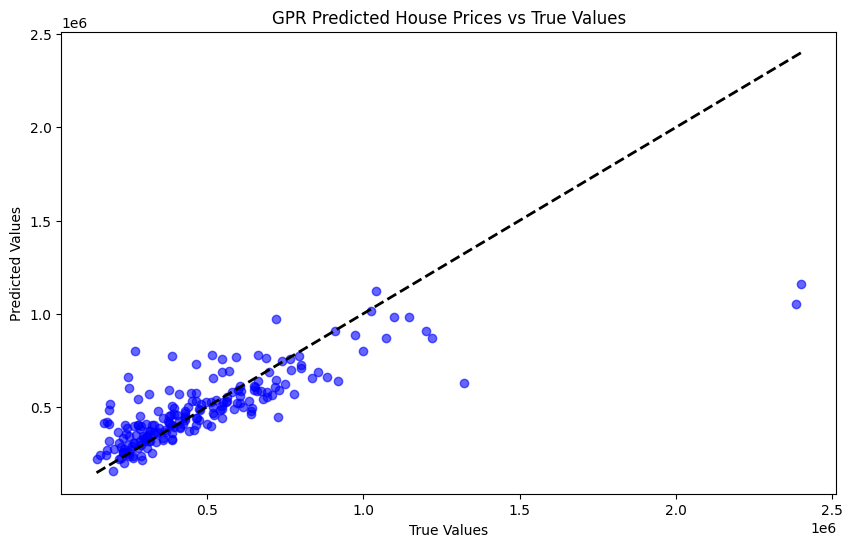

In [29]:
# Plotting the true values versus predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gpr, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GPR Predicted House Prices vs True Values')
plt.show()

In [14]:
# Prophet Model for Time Series Forecasting
# We need to bring the 'date' column back to use with Prophet
df_prophet = pd.read_csv('kc_house_data.csv', encoding='ISO-8859-1')
df_prophet['date'] = pd.to_datetime(df_prophet['date'])

In [15]:
# Select relevant columns for Prophet
df_prophet = df_prophet[['date', 'price']].dropna()

In [16]:
# Rename columns to fit Prophet's expectations
df_prophet = df_prophet.rename(columns={'date': 'ds', 'price': 'y'})


In [17]:
# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

14:31:45 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a dataframe to hold future dates
future_dates = prophet_model.make_future_dataframe(periods=365)


In [19]:
# Predict future prices
forecast = prophet_model.predict(future_dates)


In [24]:
import numpy as np
import pandas as pd
from datetime import datetime

# Assuming 'X_test' contains year, month, and day in the last three columns
# Convert these to a DataFrame for easier manipulation
date_df = pd.DataFrame({
    'year': X_test[:, -3],  # Adjust the indices based on the actual position of the date columns
    'month': X_test[:, -2],
    'day': X_test[:, -1]
})

# Validate the date components
def validate_date_components(df):
    # Ensure year is within a reasonable range
    df['year'] = df['year'].apply(lambda x: int(x) if pd.notnull(x) and 1900 <= x <= 2024 else np.nan)
    # Ensure month is between 1 and 12
    df['month'] = df['month'].apply(lambda x: int(x) if pd.notnull(x) and 1 <= x <= 12 else np.nan)
    # Ensure day is valid based on year and month (handle leap years as well)
    def valid_day(row):
        try:
            if pd.notnull(row['year']) and pd.notnull(row['month']):
                max_day = (pd.Timestamp(f"{int(row['year'])}-{int(row['month']):02d}-01") + pd.offsets.MonthEnd(1)).day
                return int(row['day']) if 1 <= row['day'] <= max_day else np.nan
            else:
                return np.nan
        except:
            return np.nan
    
    df['day'] = df.apply(valid_day, axis=1)
    return df

# Apply validation
date_df = validate_date_components(date_df)

# Drop rows with invalid dates
date_df.dropna(inplace=True)

# Ensure remaining data is in integer format
date_df = date_df.astype(int)

# Convert to datetime
test_dates = pd.to_datetime(date_df.astype(str).agg('-'.join, axis=1))

# Ensure that Prophet's forecast dates are properly formatted
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Extract the predictions corresponding to the test dates
forecast_test = forecast[forecast['ds'].isin(test_dates)]

# Check if forecast_test is empty and handle it
if forecast_test.empty:
    print("No matching dates found in forecast for test set dates.")
else:
    # Align y_test with forecast_test['ds']
    y_test_aligned = y_test.loc[test_dates.index[test_dates.isin(forecast_test['ds'])]]
    
    # Ensure y_test_aligned and forecast_test['yhat'] have the same length
    if len(y_test_aligned) == len(forecast_test['yhat']):
        prophet_mse = mean_squared_error(y_test_aligned, forecast_test['yhat'].values)
        print(f"Prophet Model MSE: {prophet_mse}")
    else:
        print("Mismatch between the number of test samples and forecast samples.")


No matching dates found in forecast for test set dates.


In [25]:
# Optional: Save the forecast to a CSV file
forecast.to_csv('house_price_forecast.csv', index=False)


C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\Lo

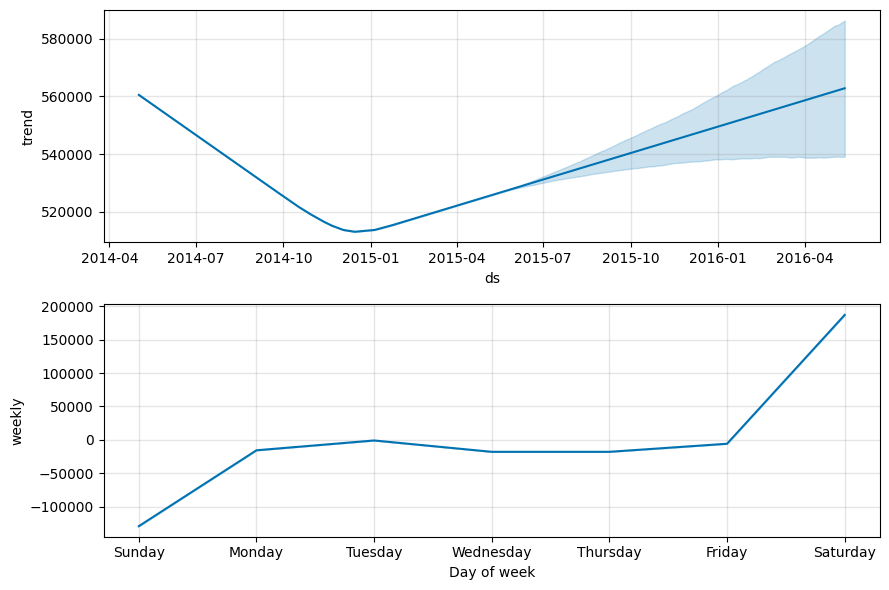

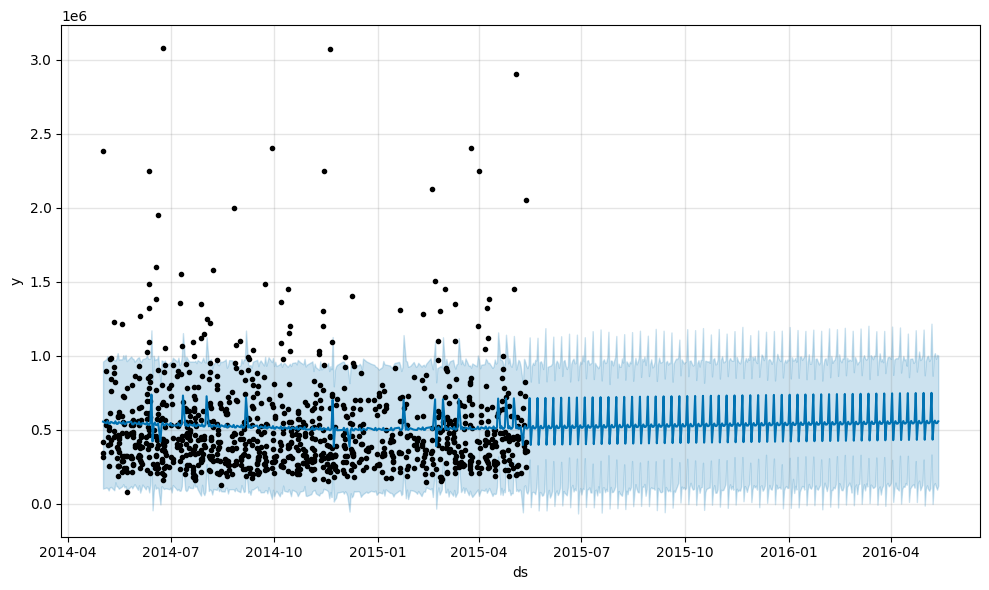

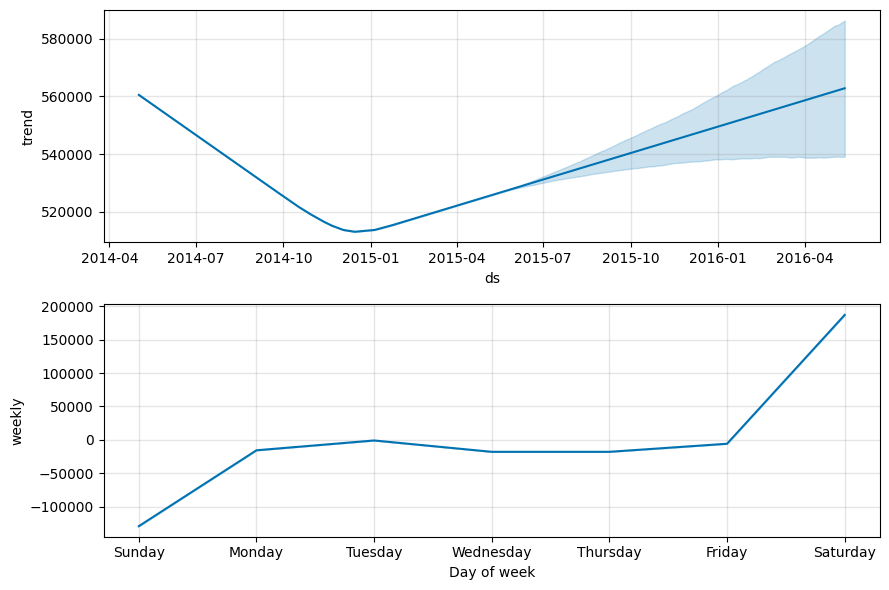

In [26]:
# Visualize the Prophet forecast
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)